In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#Load Data
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
la_2025_asset_summary = pd.read_csv(r'../../data/processed/la_2025_asset_summary.csv')
population_summary = pd.read_csv(r'../../data/processed/population_summary_by_la.csv')
df_category = pd.read_csv(r'../../data/raw/charityClassification_RegisteredCharitiesInEnglandAndWales2025.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_29268\362613131.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')


Total number of charity data: 1,794,020
Total number of charities removed: 650,504
Number of charities removed per year:
1961.0: 295
1962.0: 91
1963.0: 89
1964.0: 116
1965.0: 96
1966.0: 106
1967.0: 87
1968.0: 83
1969.0: 59
1970.0: 79
1971.0: 81
1972.0: 124
1973.0: 141
1974.0: 143
1975.0: 133
1976.0: 119
1977.0: 188
1978.0: 152
1979.0: 123
1980.0: 145
1981.0: 124
1982.0: 153
1983.0: 142
1984.0: 157
1985.0: 141
1986.0: 157
1987.0: 184
1988.0: 253
1989.0: 208
1990.0: 135
1991.0: 4,921
1992.0: 11,406
1993.0: 6,826
1994.0: 3,640
1995.0: 4,365
1996.0: 7,801
1997.0: 5,286
1998.0: 3,463
1999.0: 3,562
2000.0: 8,636
2001.0: 4,802
2002.0: 3,872
2003.0: 3,673
2004.0: 9,380
2005.0: 15,487
2006.0: 16,056
2007.0: 18,007
2008.0: 25,287
2009.0: 49,704
2010.0: 30,066
2011.0: 33,794
2012.0: 24,277
2013.0: 25,481
2014.0: 24,168
2015.0: 29,123
2016.0: 26,441
2017.0: 27,417
2018.0: 32,509
2019.0: 37,539
2020.0: 25,238
2021.0: 22,897
2022.0: 35,893
2023.0: 27,531
2024.0: 26,378
2025.0: 11,474


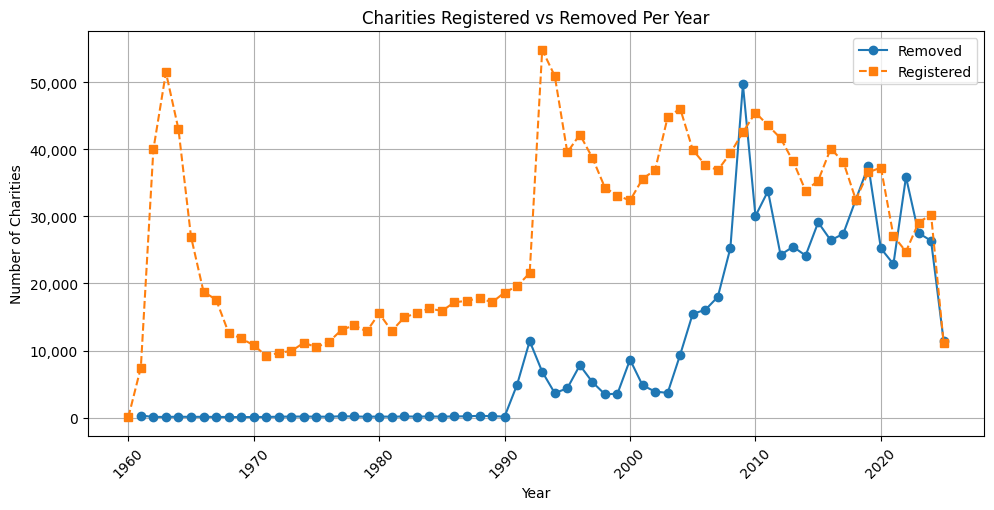

In [3]:
# Parse dates
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')

# Count removals per year
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()

# Count registrations per year
registered_by_year = dataset['date_of_registration'].dt.year.value_counts().sort_index()

# Print summary
print(f"Total number of charity data: {dataset['charity_status'].count():,}")
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

# Plot both lines
plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-', label='Removed')
plt.plot(registered_by_year.index, registered_by_year.values, marker='s', linestyle='--', label='Registered')

plt.title('Charities Registered vs Removed Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

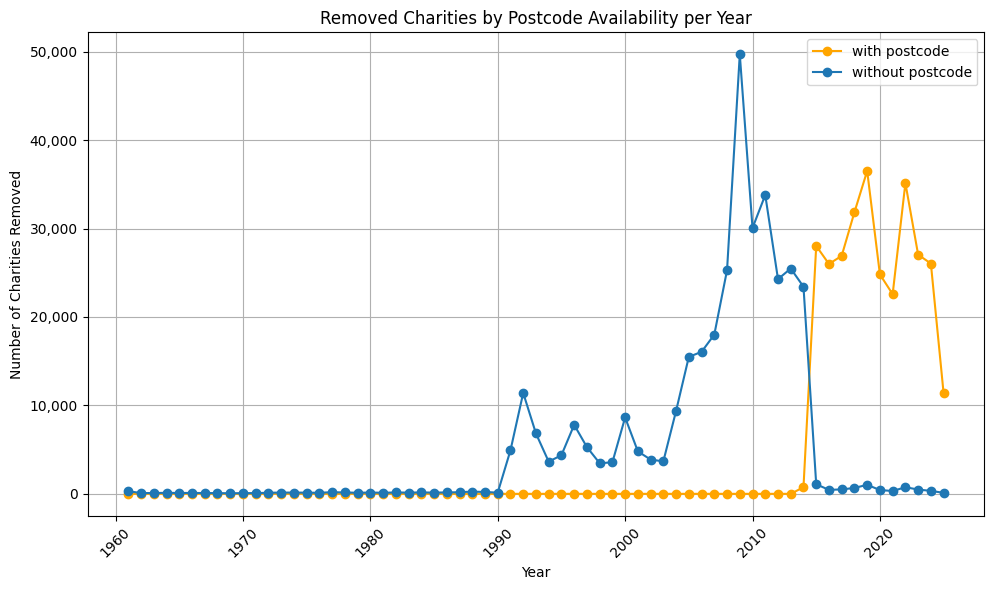

In [4]:
# Ensure datetime conversion
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

# Filter removed charities
removed = dataset[dataset['date_of_removal'].notnull()].copy()

# Create postcode status category
def classify_postcode(x):
    if pd.isnull(x):
        return 'without postcode'
    x_str = str(x).strip().lower()
    return 'with postcode' if x_str not in ['', 'nan', 'none'] else 'without postcode'

removed['postcode_status'] = removed['postcode'].apply(classify_postcode)

# Extract year of removal
removed['removal_year'] = removed['date_of_removal'].dt.year

# Group by year and postcode status
removed_by_year_postcode = (
    removed.groupby(['removal_year', 'postcode_status'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(10, 6))
color_map = {
    'without postcode': '#1f77b4',
    'with postcode': 'orange'
}
for category in removed_by_year_postcode.columns:
    plt.plot(
        removed_by_year_postcode.index,
        removed_by_year_postcode[category],
        marker='o',
        label=category,
        color=color_map.get(category, 'grey')  # fallback colour if unexpected category
    )
plt.title('Removed Charities by Postcode Availability per Year')
plt.xlabel('Year')
plt.ylabel('Number of Charities Removed')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29268\3162599160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['removed_by_year'] = inactive['date_of_removal'].dt.year
C:\Users\User\AppData\Local\Temp\ipykernel_29268\3162599160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['land_category'] = inactive['charity_has_land'].map({True: 'with land', False: 'without land'})
C:\Users\User\AppData\Local\Temp\ipykernel_29268\3162599160.py:7: SettingWithCopyWarning: 
A value is trying to be se

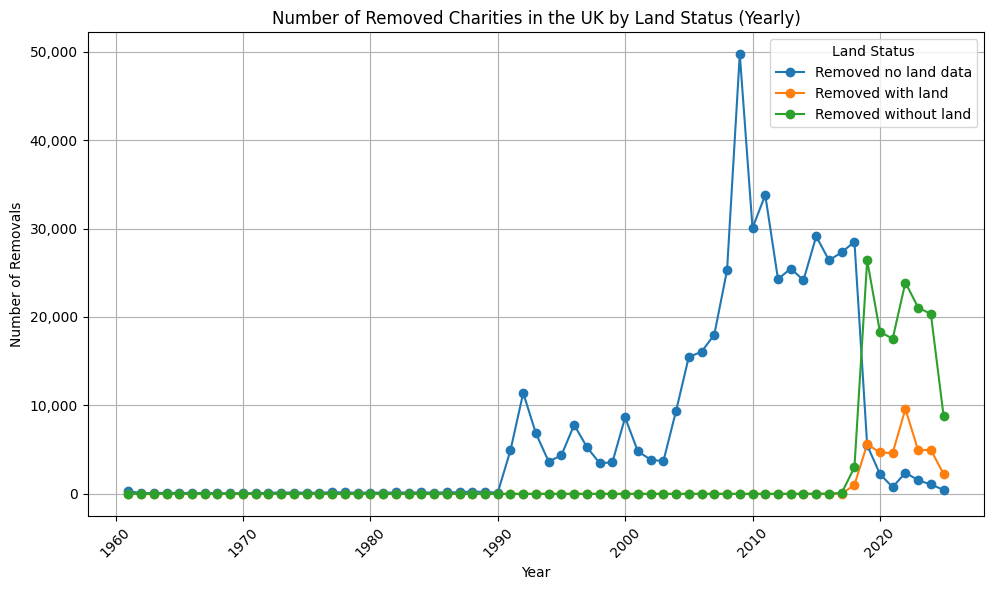

In [5]:
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
inactive = dataset[dataset['charity_status'] == 'inactive']
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()
inactive['removed_by_year'] = inactive['date_of_removal'].dt.year

inactive['land_category'] = inactive['charity_has_land'].map({True: 'with land', False: 'without land'})
inactive['land_category'] = inactive['land_category'].fillna('no land data')

# Group by year and land category
removed_by_year_land = (
    inactive
    .groupby(['removed_by_year', 'land_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(10, 6))
for column in removed_by_year_land.columns:
    plt.plot(removed_by_year_land.index, removed_by_year_land[column], marker='o', label=f"Removed {column}")

plt.title('Number of Removed Charities in the UK by Land Status (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Land Status')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_29268\2507091319.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed['age_at_removal'] = (removed['date_of_removal'] - removed['date_of_registration']).dt.days // 365
C:\Users\User\AppData\Local\Temp\ipykernel_29268\2507091319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed['age_category'] = pd.cut(removed['age_at_removal'], bins=bins, labels=labels, right=True)
C:\Users\User\AppData\Local\Temp\ipykernel_29268\2507091319.py:14: SettingWithCopyW

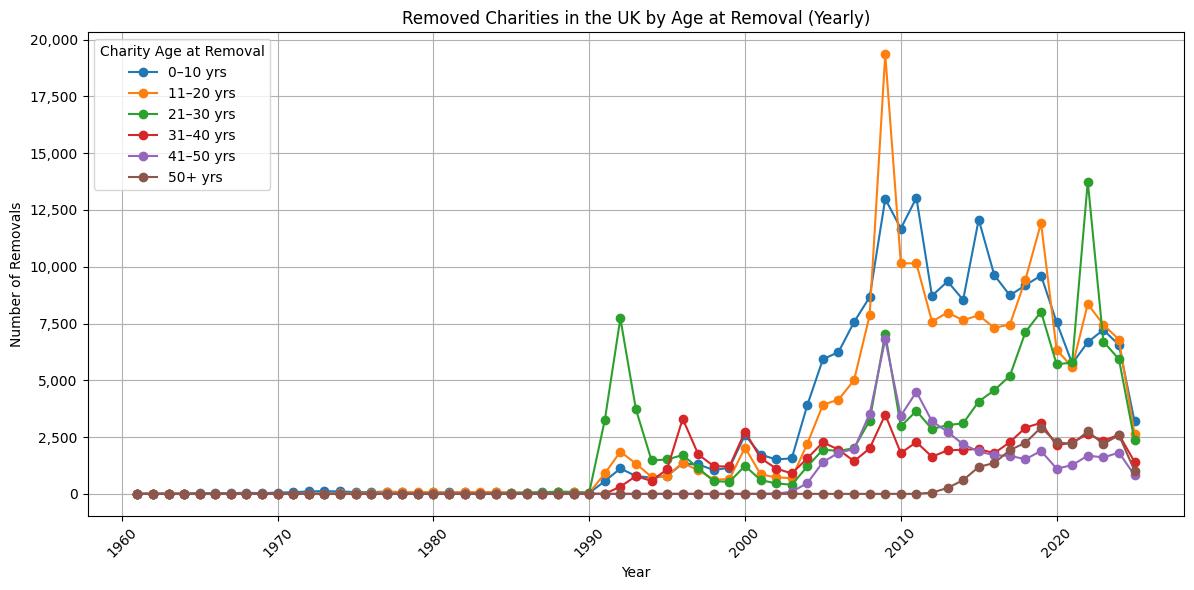

In [6]:
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

removed = dataset[dataset['date_of_removal'].notnull()]

removed['age_at_removal'] = (removed['date_of_removal'] - removed['date_of_registration']).dt.days // 365

# Bin into age categories
bins = [0, 10, 20, 30, 40, 50, 1000]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
removed['age_category'] = pd.cut(removed['age_at_removal'], bins=bins, labels=labels, right=True)

# Add year column
removed['year'] = removed['date_of_removal'].dt.year

# Group by year and age category
removed_by_year_age = (
    removed
    .groupby(['year', 'age_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(12, 6))
for column in removed_by_year_age.columns:
    plt.plot(removed_by_year_age.index, removed_by_year_age[column], marker='o', label=f"{column}")

plt.title('Removed Charities in the UK by Age at Removal (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Charity Age at Removal')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

Total number of charity data: 1,794,020
Total number of charities removed: 290,966
Number of charities removed per year:
2015.0: 29,123
2016.0: 26,441
2017.0: 27,417
2018.0: 32,509
2019.0: 37,539
2020.0: 25,238
2021.0: 22,897
2022.0: 35,893
2023.0: 27,531
2024.0: 26,378


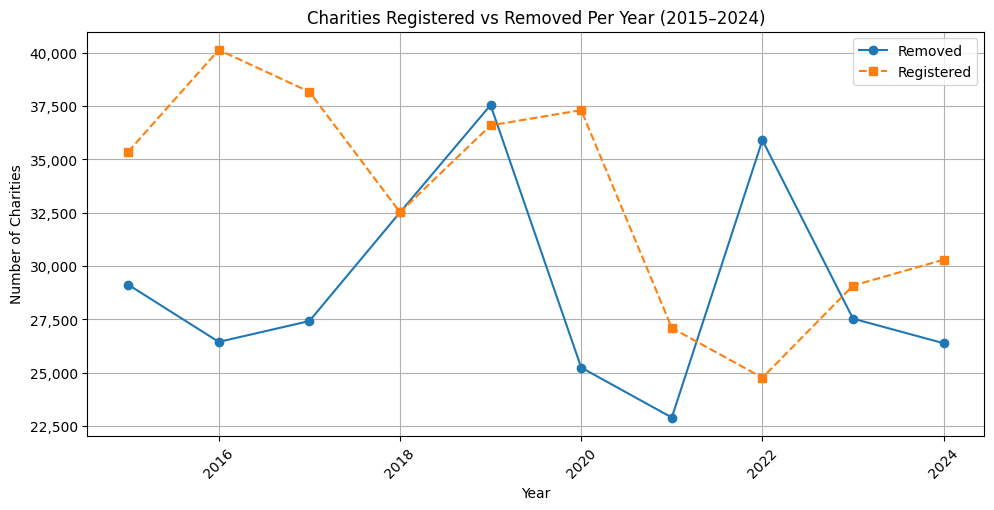

In [7]:
# Count per year
# Count per year
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()
registered_by_year = dataset['date_of_registration'].dt.year.value_counts().sort_index()

# Filter both to 2015–2024
removed_by_year = removed_by_year[(removed_by_year.index >= 2015) & (removed_by_year.index <= 2024)]
registered_by_year = registered_by_year[(registered_by_year.index >= 2015) & (registered_by_year.index <= 2024)]

# Print summary
print(f'Total number of charity data: {dataset["charity_status"].count():,}')
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

# Plot both lines
plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-', color='#1f77b4', label='Removed')
plt.plot(registered_by_year.index, registered_by_year.values, marker='s', linestyle='--', color='#ff7f0e', label='Registered')

plt.title('Charities Registered vs Removed Per Year (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

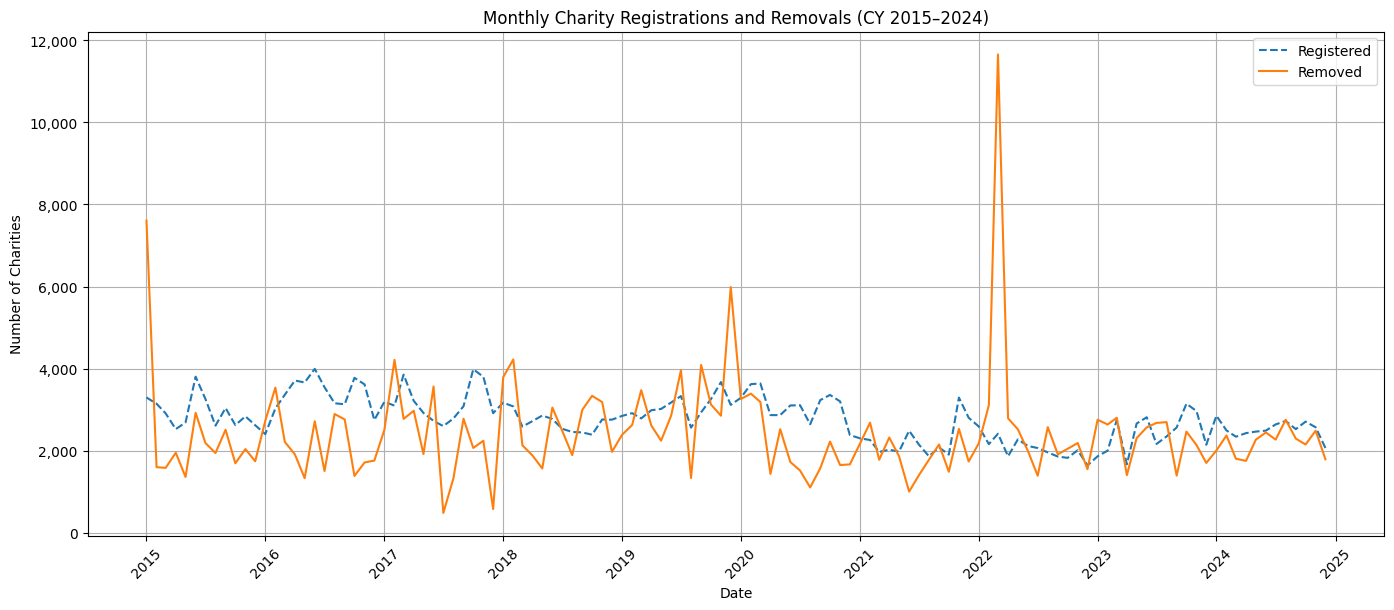

In [8]:
# Ensure datetime
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')

# Extract year-month
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')

# Count per month
removed_by_month = dataset['removal_month'].value_counts().sort_index()
registered_by_month = dataset['registration_month'].value_counts().sort_index()

# Convert PeriodIndex to datetime for plotting
removed_by_month.index = removed_by_month.index.to_timestamp()
registered_by_month.index = registered_by_month.index.to_timestamp()

# Filter to 2015–2024
removed_by_month = removed_by_month[(removed_by_month.index >= '2015-01') & (removed_by_month.index <= '2024-12')]
registered_by_month = registered_by_month[(registered_by_month.index >= '2015-01') & (registered_by_month.index <= '2024-12')]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(registered_by_month.index, registered_by_month.values, label='Registered', color='#1f77b4', linestyle='--')
plt.plot(removed_by_month.index, removed_by_month.values, label='Removed', color='#ff7f0e')


plt.title('Monthly Charity Registrations and Removals (CY 2015–2024)')
plt.xlabel('Date')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

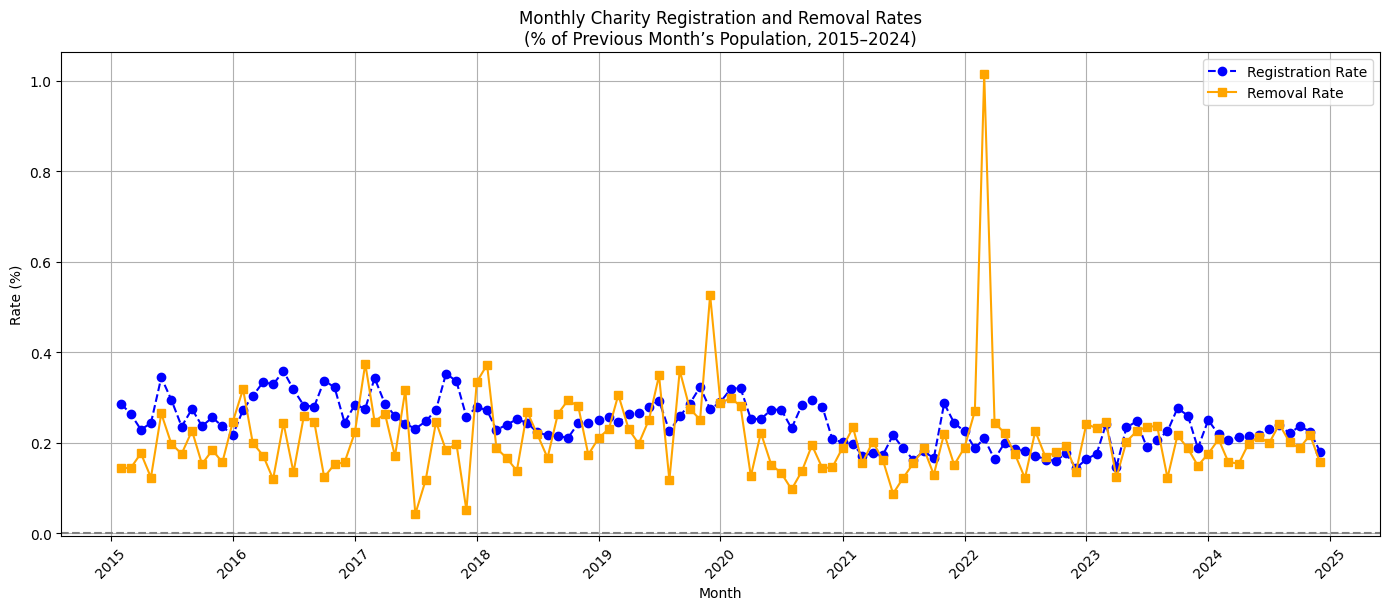

In [16]:
# Step 1: Define the full monthly range
all_months = pd.period_range(start='2014-12', end='2024-12', freq='M')

# Step 2: Calculate active population at end of each month
population_by_month = []
for month in all_months:
    active = dataset[
        (dataset['registration_month'] <= month) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month))
    ]
    population_by_month.append({'month': month, 'active': len(active)})

population_df = pd.DataFrame(population_by_month).set_index('month')
population_df = population_df[population_df.index >= pd.Period('2015-01')]  # focus on 2015–2024

# Step 3: Count registrations and removals per month
registered = dataset['registration_month'].value_counts().sort_index()
removed = dataset['removal_month'].value_counts().sort_index()

# Align indices with population_df
registered = registered.reindex(population_df.index, fill_value=0)
removed = removed.reindex(population_df.index, fill_value=0)

# Step 4: Calculate rates (registrations/removals ÷ previous month's population)
# Use population from PREVIOUS month
population_df['prev_active'] = population_df['active'].shift(1)
population_df['registered'] = registered
population_df['removed'] = removed

population_df['registration_rate'] = (population_df['registered'] / population_df['prev_active']) * 100
population_df['removal_rate'] = (population_df['removed'] / population_df['prev_active']) * 100

# Step 5: Plot
plt.figure(figsize=(14, 6))
plt.plot(population_df.index.to_timestamp(), population_df['registration_rate'], marker='o', linestyle='--', color='blue', label='Registration Rate')
plt.plot(population_df.index.to_timestamp(), population_df['removal_rate'], marker='s', linestyle='-', color='orange', label='Removal Rate')

plt.title('Monthly Charity Registration and Removal Rates\n(% of Previous Month’s Population, 2015–2024)')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.axhline(0, color='grey', linestyle='--')
plt.show()


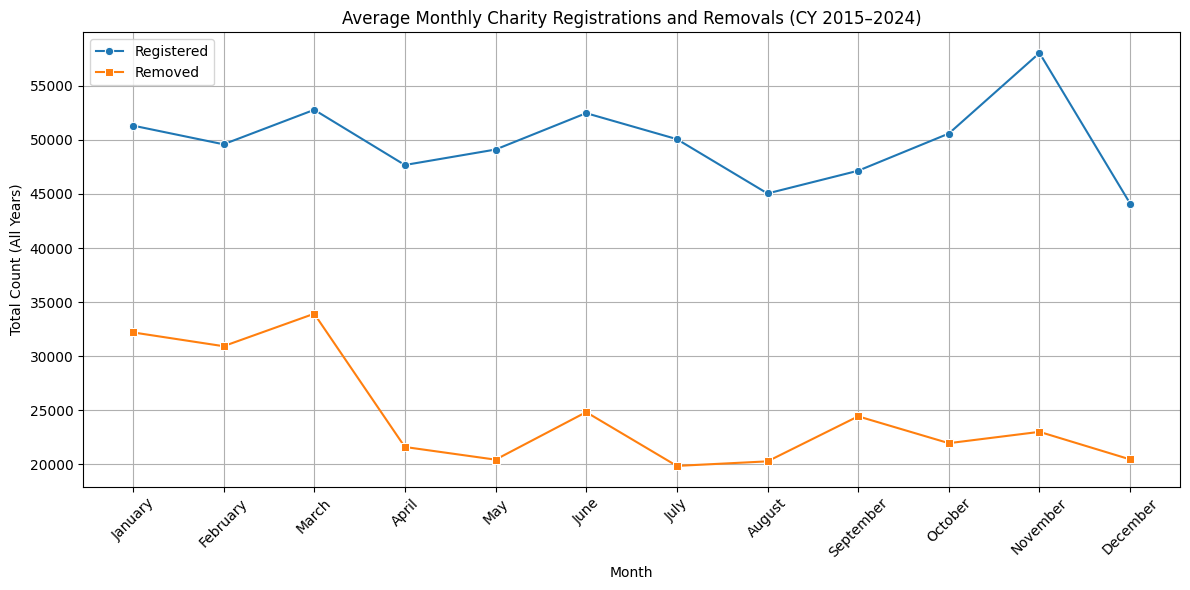

In [10]:
# Extract month names
dataset['registration_month'] = dataset['date_of_registration'].dt.month_name()
dataset['removal_month'] = dataset['date_of_removal'].dt.month_name()

# Filter valid date range
filtered = dataset[
    dataset['date_of_registration'].dt.year.between(2015, 2024) |
    dataset['date_of_removal'].dt.year.between(2015, 2024)
]

# Group and count by month
reg_by_month = (
    filtered['registration_month'].value_counts()
    .reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
)

rem_by_month = (
    filtered['removal_month'].value_counts()
    .reindex(reg_by_month.index)
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=reg_by_month.index, y=reg_by_month.values, marker='o', label='Registered')
sns.lineplot(x=rem_by_month.index, y=rem_by_month.values, marker='s', label='Removed')

plt.title("Average Monthly Charity Registrations and Removals (CY 2015–2024)")
plt.xlabel("Month")
plt.ylabel("Total Count (All Years)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


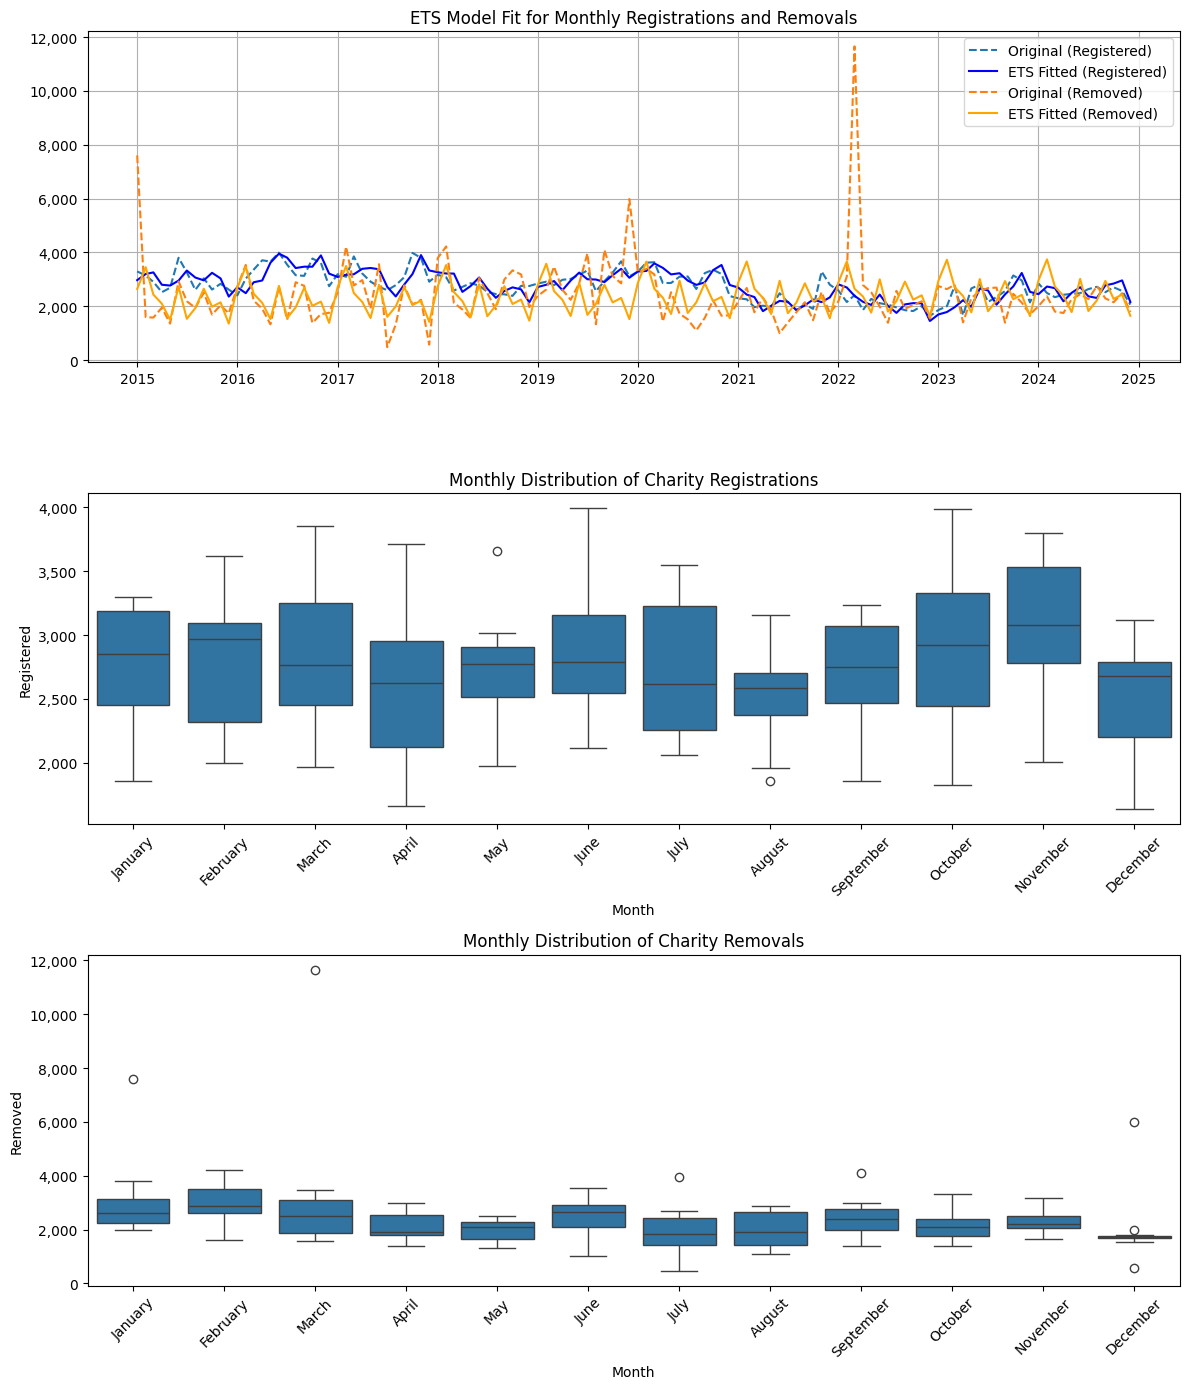

In [11]:
# Extract year-month as Period
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')

# Count per month
removed_by_month = dataset['removal_month'].value_counts().sort_index()
registered_by_month = dataset['registration_month'].value_counts().sort_index()

# Filter to 2015–2024
removed_by_month = removed_by_month[(removed_by_month.index >= '2015-01') & (removed_by_month.index <= '2024-12')]
registered_by_month = registered_by_month[(registered_by_month.index >= '2015-01') & (registered_by_month.index <= '2024-12')]

# Convert PeriodIndex to Timestamp for modeling and plotting
removed_by_month.index = removed_by_month.index.to_timestamp()
registered_by_month.index = registered_by_month.index.to_timestamp()

# Apply ETS model (additive trend and seasonality)
ets_model_removed = ExponentialSmoothing(removed_by_month, trend='add', seasonal='add', seasonal_periods=12).fit()
ets_model_registered = ExponentialSmoothing(registered_by_month, trend='add', seasonal='add', seasonal_periods=12).fit()

# Prepare for boxplots
removed_df = removed_by_month.reset_index()
removed_df.columns = ['Date', 'Removed']
removed_df['Month'] = removed_df['Date'].dt.month_name()

registered_df = registered_by_month.reset_index()
registered_df.columns = ['Date', 'Registered']
registered_df['Month'] = registered_df['Date'].dt.month_name()

# Ensure month order for boxplot
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)

# ETS Model Trends
axes[0].plot(registered_by_month.index, registered_by_month.values, linestyle='--', label='Original (Registered)')
axes[0].plot(registered_by_month.index, ets_model_registered.fittedvalues, color='blue', label='ETS Fitted (Registered)')
axes[0].plot(removed_by_month.index, removed_by_month.values, linestyle='--', label='Original (Removed)')
axes[0].plot(removed_by_month.index, ets_model_removed.fittedvalues, color='orange', label='ETS Fitted (Removed)')
axes[0].set_title('ETS Model Fit for Monthly Registrations and Removals')
axes[0].legend()
axes[0].grid(True)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Boxplot for Removals
# Boxplot for Registrations
sns.boxplot(data=registered_df, x='Month', y='Registered', order=month_order, ax=axes[1])
axes[1].set_title('Monthly Distribution of Charity Registrations')
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

sns.boxplot(data=removed_df, x='Month', y='Removed', order=month_order, ax=axes[2])
axes[2].set_title('Monthly Distribution of Charity Removals')
axes[2].tick_params(axis='x', rotation=45)
axes[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

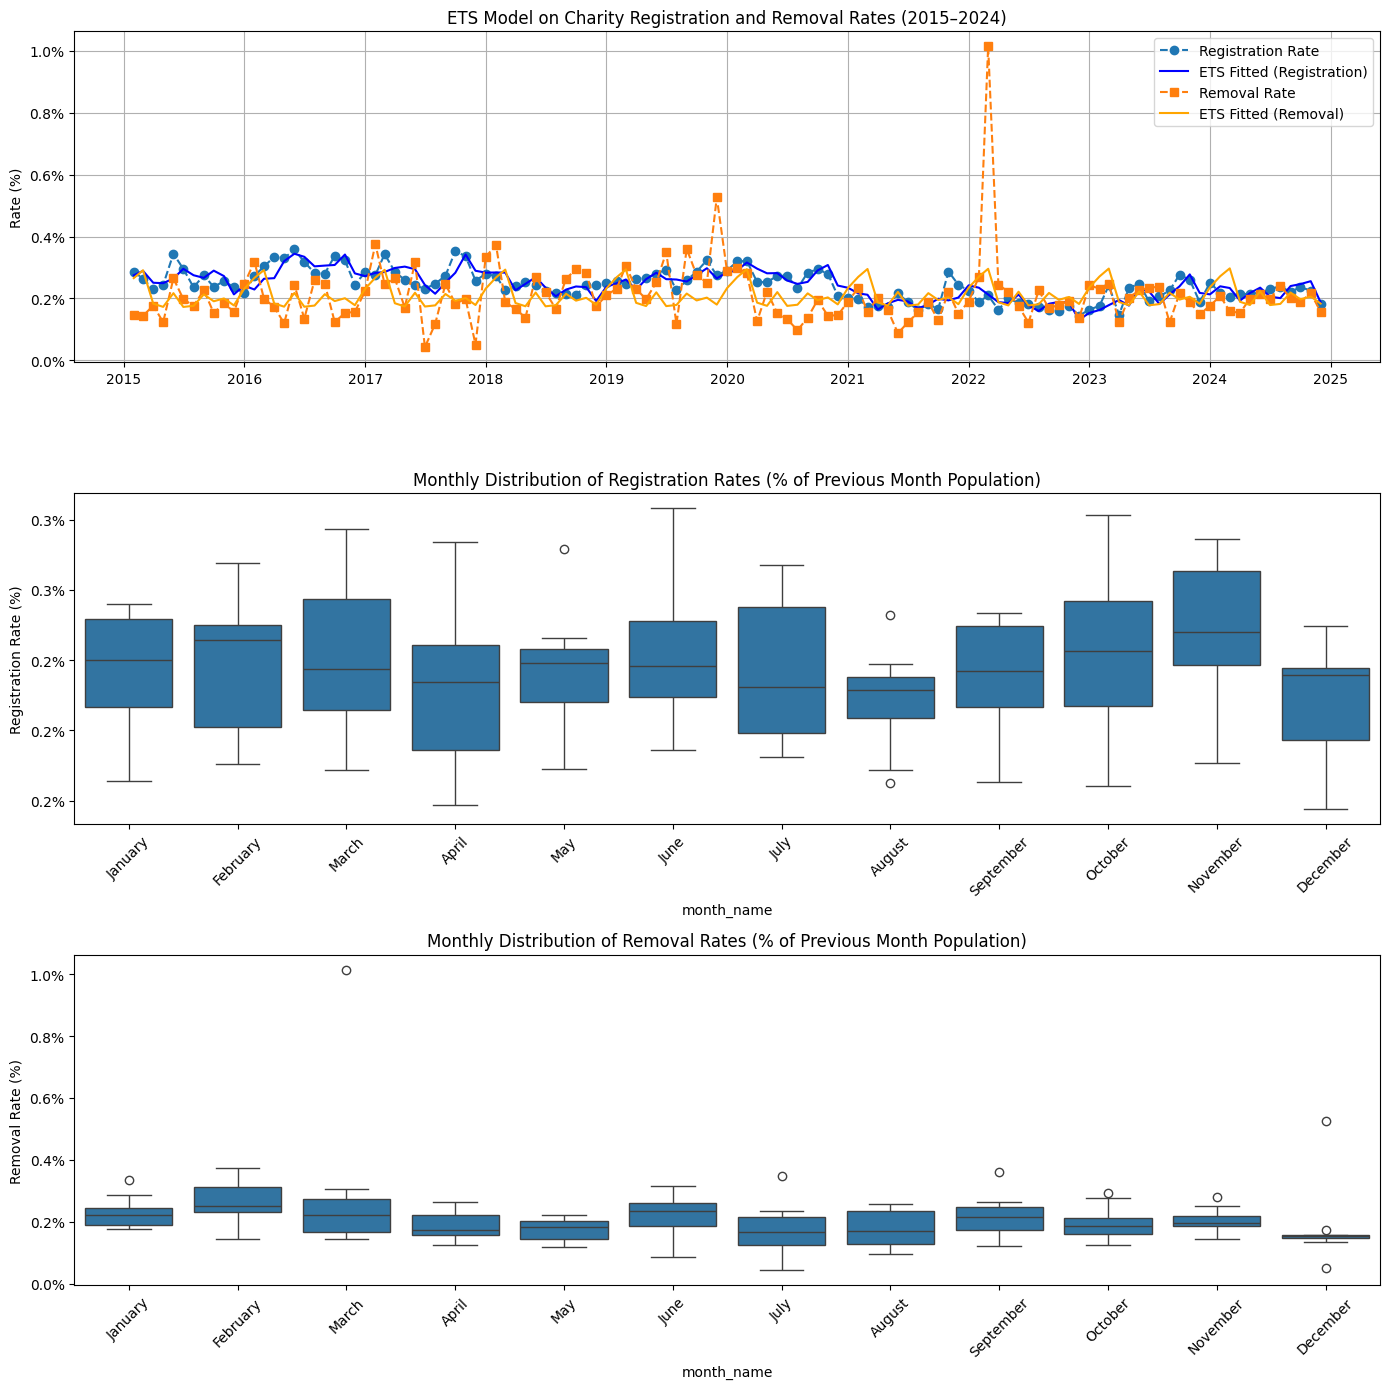

In [15]:
# --- ETS model on registration/removal rate ---
# Drop NA from beginning (due to shift)
rate_df = population_df.dropna(subset=['registration_rate', 'removal_rate']).copy()

# Fit ETS models (additive trend and seasonality)
ets_reg = ExponentialSmoothing(
    rate_df['registration_rate'], trend='add', seasonal='add', seasonal_periods=12
).fit()
ets_rem = ExponentialSmoothing(
    rate_df['removal_rate'], trend='add', seasonal='add', seasonal_periods=12
).fit()

# --- Boxplot preparation ---
rate_df['month_name'] = rate_df.index.to_timestamp().month_name()
rate_df['month_number'] = rate_df.index.month  # for correct order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=False)

# Plot 1: ETS trend lines
axes[0].plot(rate_df.index.to_timestamp(), rate_df['registration_rate'], linestyle='--', marker='o', label='Registration Rate')
axes[0].plot(rate_df.index.to_timestamp(), ets_reg.fittedvalues, color='blue', label='ETS Fitted (Registration)')
axes[0].plot(rate_df.index.to_timestamp(), rate_df['removal_rate'], linestyle='--', marker='s', label='Removal Rate')
axes[0].plot(rate_df.index.to_timestamp(), ets_rem.fittedvalues, color='orange', label='ETS Fitted (Removal)')

axes[0].set_title('ETS Model on Charity Registration and Removal Rates (2015–2024)')
axes[0].set_ylabel('Rate (%)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Boxplot – Registration Rate
sns.boxplot(
    data=rate_df, x='month_name', y='registration_rate',
    order=month_order, ax=axes[1]
)
axes[1].set_title('Monthly Distribution of Registration Rates (% of Previous Month Population)')
axes[1].set_ylabel('Registration Rate (%)')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Boxplot – Removal Rate
sns.boxplot(
    data=rate_df, x='month_name', y='removal_rate',
    order=month_order, ax=axes[2]
)
axes[2].set_title('Monthly Distribution of Removal Rates (% of Previous Month Population)')
axes[2].set_ylabel('Removal Rate (%)')
axes[2].tick_params(axis='x', rotation=45)

# Format y-axes
for ax in axes:
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.1f}%'))

plt.tight_layout()
plt.show()
